# Machine Learning project a.y. 2021/2022

## Scikit-learn MLP model

## Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from dataclasses import dataclass

## Loading training set and blind test set

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

## Evaluation metrics

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [ ]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

We also define a random state (seed) to allow reproducibility on our experiments

In [ ]:
RS_NUMBER = 69

## MONK Dataset
### MONK1

In [ ]:
def load_monk(path_train, path_test):
    df_monk_train = pd.read_csv(path_train, sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
    df_monk_train.drop(labels='id', axis=1, inplace=True)

    df_monk_test = pd.read_csv(path_test, sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
    df_monk_test.drop(labels='id', axis=1, inplace=True)

    return df_monk_train, df_monk_test

### Loading MONK1 dataset

In [ ]:
df_monk1_train, df_monk1_test = load_monk('./data/MONK/monks-1.train', './data/MONK/monks-1.test')

In [ ]:
df_monk1_train.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [ ]:
def split_train_test(df_monk_train, df_monk_test):
    target_train = df_monk_train[['class']]
    df_monk_train.drop(labels='class', axis=1, inplace=True)
    target_test = df_monk_test[['class']]
    df_monk_test.drop(labels='class', axis=1, inplace=True)
    X_train = df_monk_train.values #returns a ndarray
    y_train = target_train.values.ravel() #flattens the array into a 1-dimensional array
    X_test = df_monk_test.values
    y_test = target_test.values.ravel()

    return X_train, y_train, X_test, y_test

### Splitting the MONK1 dataset into train and test set

In [ ]:
X_train_M1, y_train_M1, X_test_M1, y_test_M1 = split_train_test(df_monk1_train, df_monk1_test)

### One hot encoding of MONK1
In the MONK dataset we have the categories encoded using label encoding (e.g. 0,1,2,..), we need to use one hot encoding in order to have better results (e.g. 001, 010, ..). 

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M1)
X_train_M1 = enc_train.transform(X_train_M1).toarray()
print(X_train_M1.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M1)
X_test_M1 = enc_test.transform(X_test_M1).toarray()
print(X_test_M1.shape)

(124, 17)
(432, 17)


### Training phase for MONK1
We train a simple classifier using batch size = 1 (for the MONK dataset it is not necessary to do the hyperparameter tuning)

In [ ]:
classifier_M1 = MLPClassifier(random_state=RS_NUMBER, batch_size=1).fit(X_train_M1, y_train_M1)
eval_model = MLPClassifier(random_state=RS_NUMBER, batch_size=1)

In [ ]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score_monk(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []

    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train, classes = np.unique(y_train))
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_loss.append(log_loss(y_train, y_train_predicted))
        train_scores.append(accuracy_score(y_train, y_train_predicted))
        #result on test set
        test_loss.append(log_loss(y_test, y_test_predicted))
        test_scores.append(accuracy_score(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


In [ ]:
train_scores_M1, test_scores_M1, train_loss_M1, test_loss_M1 = fit_and_score_monk(classifier_M1.n_iter_, eval_model, X_train_M1, y_train_M1, X_test_M1, y_test_M1)

### Loss curve for MONK1

In [ ]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Epoch');

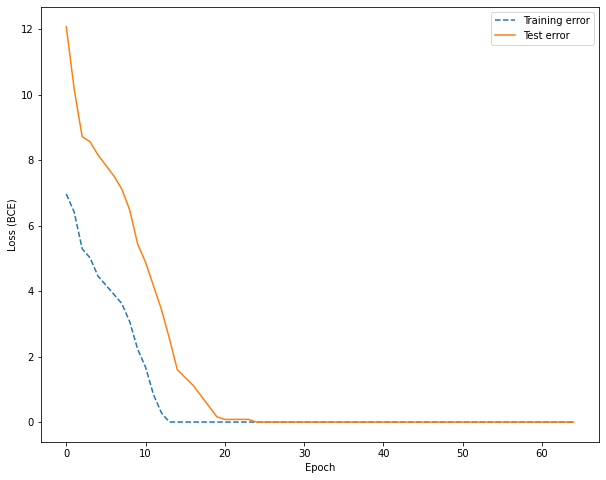

In [ ]:
plot_learning_curves(train_loss_M1, test_loss_M1, classifier_M1.n_iter_, 'Loss (BCE)')

### Learning curves for MONK1

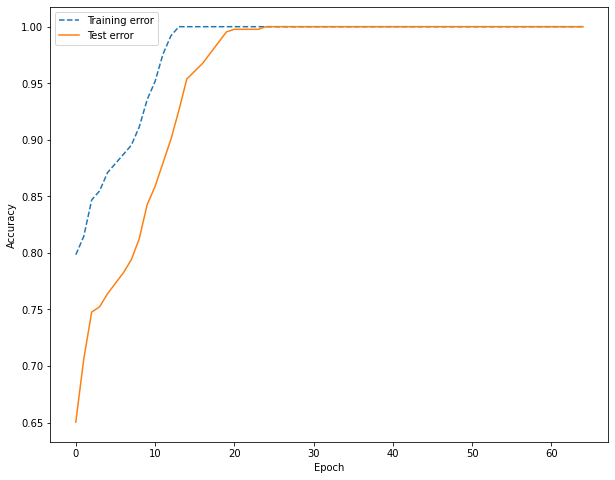

In [ ]:
plot_learning_curves(train_scores_M1, test_scores_M1, classifier_M1.n_iter_, 'Accuracy')

### Accuracy and MEE for MONK1

In [ ]:
y_predicted_M1 = classifier_M1.predict(X_test_M1)
print(f"Accuracy on MONK1: {classifier_M1.score(X_test_M1, y_test_M1)}")
print(f"MEE on MONK1: {(np.linalg.norm(y_predicted_M1-y_test_M1))}") # MEE distance (a.k.a. norm 2)

Accuracy on MONK1: 1.0
MEE on MONK1: 0.0


### MONK2

### Loading MONK2 dataset

In [ ]:
df_monk2_train, df_monk2_test = load_monk('./data/MONK/monks-2.train', './data/MONK/monks-2.test')

In [ ]:
df_monk2_train.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1


### Splitting MONK2 dataset

In [ ]:
X_train_M2, y_train_M2, X_test_M2, y_test_M2 = split_train_test(df_monk2_train, df_monk2_test)

### One hot encoding on MONK2

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M2)
X_train_M2 = enc_train.transform(X_train_M2).toarray()
print(X_train_M2.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M2)
X_test_M2 = enc_test.transform(X_test_M2).toarray()
print(X_test_M2.shape)

(169, 17)
(432, 17)


### Training phase for MONK2

In [ ]:
classifier_M2 = MLPClassifier(random_state=RS_NUMBER, batch_size=1).fit(X_train_M2, y_train_M2)
eval_model = MLPClassifier(random_state=RS_NUMBER, batch_size=1)

In [ ]:
train_scores_M2, test_scores_M2, train_loss_M2, test_loss_M2 = fit_and_score_monk(classifier_M2.n_iter_, eval_model, X_train_M2, y_train_M2, X_test_M2, y_test_M2)

### Loss curve for MONK2

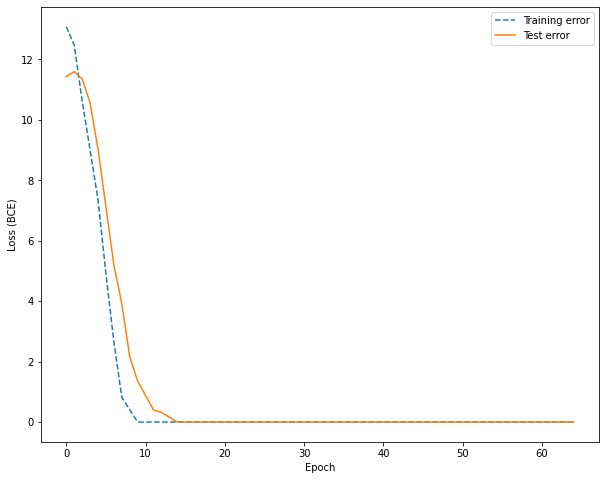

In [ ]:
plot_learning_curves(train_loss_M2, test_loss_M2, classifier_M2.n_iter_, "Loss (BCE)")

### Learning curves for MONK2

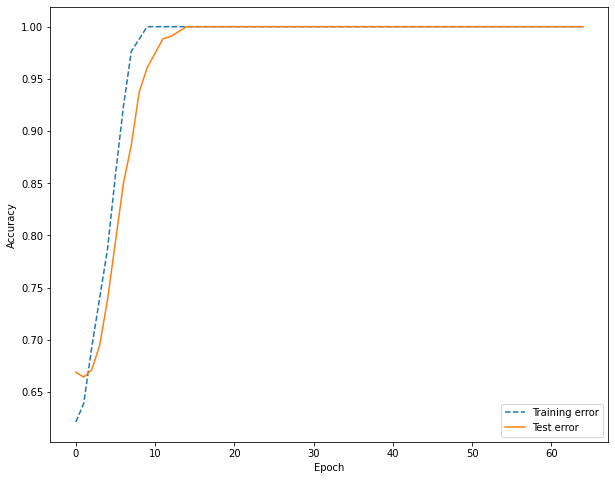

In [ ]:
plot_learning_curves(train_scores_M2, test_scores_M2, classifier_M2.n_iter_, 'Accuracy')

### Accuracy and MEE on MONK2

In [ ]:
y_predicted_M2 = classifier_M2.predict(X_test_M2)
print(f"Accuracy on MONK2: {classifier_M2.score(X_test_M2, y_test_M2)}")
print(f"MEE on MONK2: {(np.linalg.norm(y_predicted_M2-y_test_M2))}") # MEE distance (a.k.a. norm 2)

Accuracy on MONK2: 1.0
MEE on MONK2: 0.0


### MONK3

### Loading MONK3 dataset

In [ ]:
df_monk3_train, df_monk3_test = load_monk('./data/MONK/monks-3.train', './data/MONK/monks-3.test')

In [ ]:
df_monk3_train.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


### Splitting MONK3 dataset

In [ ]:
X_train_M3, y_train_M3, X_test_M3, y_test_M3 = split_train_test(df_monk3_train, df_monk3_test)

### One hot encoding on MONK3

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M3)
X_train_M3 = enc_train.transform(X_train_M3).toarray()
print(X_train_M3.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M3)
X_test_M3 = enc_test.transform(X_test_M3).toarray()
print(X_test_M3.shape)

(122, 17)
(432, 17)


### Training phase on MONK3

In [ ]:
classifier_M3 = MLPClassifier(random_state=RS_NUMBER, batch_size=1, alpha=0.015).fit(X_train_M3, y_train_M3)
eval_model = MLPClassifier(random_state=RS_NUMBER, batch_size=1, alpha = 0.015)

In [ ]:
train_scores_M3, test_scores_M3, train_loss_M3, test_loss_M3 = fit_and_score_monk(classifier_M3.n_iter_, eval_model, X_train_M3, y_train_M3, X_test_M3, y_test_M3)

### Loss curve for MONK3

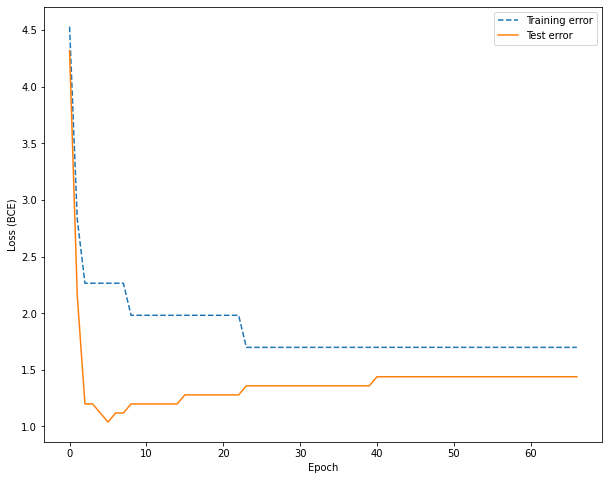

In [ ]:
plot_learning_curves(train_loss_M3, test_loss_M3, classifier_M3.n_iter_, "Loss (BCE)")

### Learning curves for MONK3

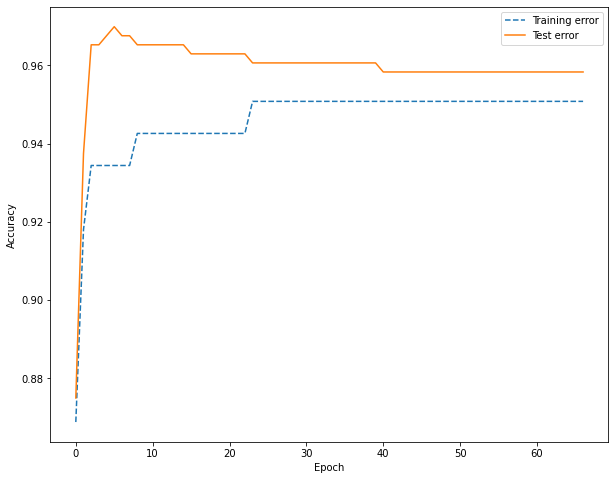

In [ ]:
plot_learning_curves(train_scores_M3, test_scores_M3, classifier_M3.n_iter_, 'Accuracy')
#normal settings tends to overfit, alpha was increased in order to regularize the model 

In [ ]:
y_predicted_M3 = classifier_M3.predict(X_test_M3)
print(f"Accuracy on MONK3: {classifier_M3.score(X_test_M3, y_test_M3)}")
print(f"MEE on MONK3: {(np.linalg.norm(y_predicted_M3-y_test_M3))}") # MEE distance (a.k.a. norm 2)

Accuracy on MONK3: 0.9768518518518519
MEE on MONK3: 3.1622776601683795


## Regression task

### Preparing the training set

In [ ]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [ ]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values
X_all = X
y_all = y

In [ ]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


### Internal Test set
We split the data set obtaining an internal test set (10%), we will use this internal test at the end to test internally the generalization error

In [ ]:
X, X_internal_test, y, y_internal_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)
print(f"X shape: {X.shape}")
print(f"X internal test shape: {X_internal_test.shape}")
print(f"y shape: {y.shape}")
print(f"y internal test shape: {y_internal_test.shape}")

X shape: (1329, 10)
X internal test shape: (148, 10)
y shape: (1329, 2)
y internal test shape: (148, 2)


In [ ]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train)
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mee(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mean_squared_error(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


## Randomized Search

In [ ]:
# define the number of iterations
n_iter_search = 2500
# define number of k-folds
k = 10

In [ ]:
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    "hidden_layer_sizes": [
        (5,),(10,),(25,),(50,),(100,),
        (5, 5),(10, 10),(25, 25),(50, 50),(100, 100),],
    "activation" : ["logistic", "tanh", "relu"],
    "solver": ["sgd", "adam"],
    "learning_rate": ["constant", "adaptive", "invscaling"],
    "learning_rate_init": uniform(0.01, 0.5),
    "alpha": uniform(0.0001, 0.1),
    "momentum": [0.1, 0.3, 0.5, 0.7, 0.9, 1],
    "batch_size": randint(1, X.shape[0]),
    "n_iter_no_change": [5,15,25],
    "random_state": [RS_NUMBER],
    "tol": uniform(0.001,0.0001),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [5000],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


In [ ]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand1_search.csv")

In [ ]:
df_results = pd.read_csv("sklearn_results/rand1_search.csv")
df_results.head()


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2438,0.924597,0.214298,0.001617,0.000487,logistic,0.057493,369,True,"(25, 25)",...,1.174750,1.241281,1.241496,1.095609,1.054232,1.138301,1.039552,1.117444,0.079109,2152
1,1824,1.771426,0.534858,0.003468,0.000838,tanh,0.031394,89,True,"(100, 100)",...,1.201119,1.259702,1.201839,1.138097,1.091507,1.215308,1.016217,1.146062,0.069490,2151
2,1161,0.660263,0.135156,0.001648,0.000430,logistic,0.025322,172,True,"(50, 50)",...,1.304903,1.230153,1.231405,1.143032,1.079665,1.257512,1.067856,1.146724,0.096540,2150
3,1245,0.323438,0.047428,0.001485,0.000394,logistic,0.019904,326,True,"(25, 25)",...,1.250511,1.230601,1.204194,1.162275,1.055677,1.245568,1.104288,1.148239,0.083083,2149
4,1946,3.045949,0.194789,0.001290,0.000379,logistic,0.073744,38,True,"(25,)",...,1.253685,1.205428,1.239073,1.160771,1.053841,1.228592,1.027436,1.148809,0.082069,2148


In [ ]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1174439906541251

Best params: {'activation': 'logistic', 'alpha': 0.057493403584900335, 'batch_size': 369, 'early_stopping': True, 'hidden_layer_sizes': (25, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.06930818775723423, 'max_iter': 5000, 'momentum': 0.5, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'adam', 'tol': 0.0010756264781396601, 'validation_fraction': 0.2}


In [ ]:
@dataclass
class GridSearchRanges:
    '''Class of keeping track of the min and max values for the hyperparameters tuning'''
    
    hidden_range = []
    min_lr_init = 0
    max_lr_init = 0
    min_alpha = 0
    max_alpha = 0
    min_bs = 0
    max_bs = 0
    n_iter_no_change = 0
    min_tol = 0
    max_tol = 0
    min_momentum = 0
    max_momentum = 0
    
    def set_ranges(self):

        self.hidden_range = np.unique(df_results['param_hidden_layer_sizes'])
        self.hidden_range = self.hidden_range.ravel() #convert to array
        print(self.hidden_range)

        self.min_lr_init = np.min(df_results['param_learning_rate_init'])
        self.max_lr_init = np.max(df_results['param_learning_rate_init'])
        print(f"LR: [{self.min_lr_init}, {self.max_lr_init}]")

        self.min_alpha = np.min(df_results['param_alpha'])
        self.max_alpha = np.max(df_results['param_alpha'])
        print(f"alpha: [{self.min_alpha}, {self.max_alpha}]")

        self.min_bs = np.min(df_results['param_batch_size'])
        self.max_bs = np.max(df_results['param_batch_size'])
        print(f"BATCH: [{self.min_bs}, {self.max_bs}]")

        self.n_iter_no_change_range = np.unique(df_results['param_n_iter_no_change'])
        self.n_iter_no_change_range = self.n_iter_no_change_range.ravel()
        print(f"n_iter_no_change: {self.n_iter_no_change_range}")

        self.min_tol = np.min(df_results['param_tol'])
        self.max_tol = np.max(df_results['param_tol'])
        print(f"TOL: [{self.min_tol}, {self.max_tol}]")
    
        self.min_momentum = np.min(df_results['param_momentum'])
        self.max_momentum = np.max(df_results['param_momentum'])
        print(f"MOMENTUM: [{self.min_momentum}, {self.max_momentum}]")
    
    

In [ ]:
gs = GridSearchRanges()
gs.set_ranges()
gs.hidden_range = [ast.literal_eval(x) for x in gs.hidden_range]

['(10, 10)' '(100, 100)' '(100,)' '(25, 25)' '(25,)' '(50, 50)' '(50,)']
LR: [0.0192386038015907, 0.505114892181715]
alpha: [0.0008978442638145, 0.0996658555604874]
BATCH: [26, 882]
n_iter_no_change: [ 5 15 25]
TOL: [0.0010033859594673, 0.0010982682330194]
MOMENTUM: [0.1, 1.0]


### Second Randomized Search using min e max values

In [ ]:
%%script false --no-raise-error

# define the parameters values
params = {
    "hidden_layer_sizes": gs.hidden_range,
    "activation" : ["logistic", "tanh"],
    "solver": ["sgd", "adam"],
    "learning_rate": ["adaptive", "invscaling"],
    "learning_rate_init": uniform(gs.min_lr_init, gs.max_lr_init),
    "alpha": uniform(gs.min_alpha, gs.max_alpha),
    "batch_size": randint(gs.min_bs, gs.max_bs),
    "n_iter_no_change": gs.n_iter_no_change_range,
    "momentum": randint(gs.min_momentum, gs.max_momentum),
    "random_state": [RS_NUMBER],
    "tol": uniform(gs.min_tol,gs.max_tol),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [5000],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state = RS_NUMBER,
    verbose=10,
)
# run the grid search
rand_gs.fit(X, y)


In [ ]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand2_search.csv")

In [ ]:
df_results = pd.read_csv("sklearn_results/rand2_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,336,0.366600,0.031369,0.000973,0.000240,logistic,0.043452,294,True,"(25, 25)",...,1.194224,1.233452,1.241300,1.105346,1.075460,1.206020,0.986820,1.122743,0.092387,2469
1,2025,0.315977,0.041927,0.000986,0.000255,logistic,0.080896,169,True,"(25, 25)",...,1.201474,1.213449,1.262260,1.053729,1.031668,1.199535,1.046373,1.125705,0.090018,2468
2,29,1.704784,0.152342,0.002316,0.000619,logistic,0.005874,321,True,"(100, 100)",...,1.272186,1.193809,1.224056,1.118355,1.082953,1.266536,1.005330,1.137963,0.095794,2467
3,1800,0.619749,0.136678,0.001234,0.000368,logistic,0.012528,129,True,"(50, 50)",...,1.252453,1.281863,1.200873,1.148883,1.083702,1.213549,1.048826,1.138548,0.089392,2466
4,1463,0.352430,0.034045,0.000913,0.000208,logistic,0.061056,134,True,"(10, 10)",...,1.252662,1.203745,1.262695,1.126897,1.104009,1.173003,1.057562,1.141133,0.084081,2465


In [ ]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1227429400609368

Best params: {'activation': 'logistic', 'alpha': 0.0434521506286926, 'batch_size': 294, 'early_stopping': True, 'hidden_layer_sizes': (25, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.05670010901640851, 'max_iter': 5000, 'momentum': 0, 'n_iter_no_change': 15, 'random_state': 69, 'solver': 'adam', 'tol': 0.0010510803946533257, 'validation_fraction': 0.2}


We save the top 10 best models for later

In [ ]:
best_models = list() #list of the top ten models of the final randomized search
for i in range(10):
    best_params_i = df_results['params'][i]
    best_params_i = ast.literal_eval(best_params_i)
    model_i = MLPRegressor(**best_params_i)
    best_models.append(model_i)

In [ ]:
best_params = ast.literal_eval(best_params)

In [ ]:
model = MLPRegressor(**best_params)
model.fit(X, y)
best_params['early_stopping'] = False
eval_model = MLPRegressor(**best_params)

In [ ]:
y_predicted = model.predict(X)
print(f"Accuracy: {model.score(X, y)}")
print(f"MEE: {mee(y, y_predicted)}")

Accuracy: 0.9487366012680531
MEE: 1.0512935569372814


In [ ]:
y_predicted_internal = model.predict(X_internal_test)
print(f"Accuracy: {model.score(X_internal_test, y_internal_test)}")
print(f"MEE: {mee(y_internal_test, y_predicted_internal)}")

Accuracy: 0.931042189429351
MEE: 1.1156016505999315


In [ ]:
train_scores, test_scores, train_loss, test_loss = fit_and_score(model.n_iter_, eval_model, X, y, X_internal_test, y_internal_test)

 ## Loss Curves

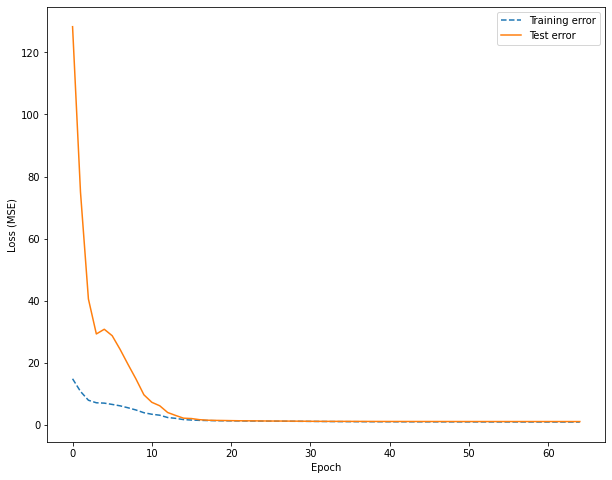

In [ ]:
plot_learning_curves(train_loss, test_loss, model.n_iter_, "Loss (MSE)")

## Learning Curves

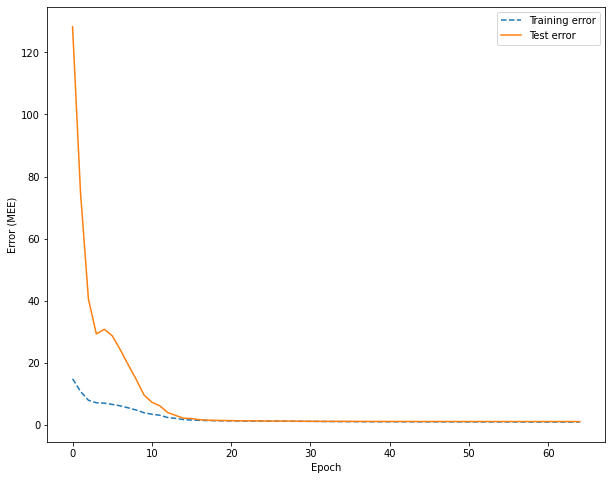

In [ ]:
plot_learning_curves(train_scores, test_scores, model.n_iter_, "Error (MEE)")

### Plot of coordinates x and y from the training set

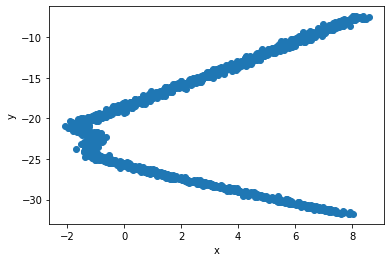

In [ ]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_visual['x'], df_visual['y'])

In [ ]:
def plot_coordinates(model, X, true_y = None):
    y_predicted = model.predict(X)
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')


### Predicted points on internal test set

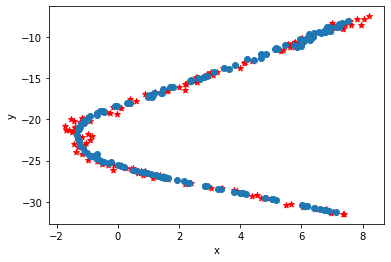

In [ ]:
plot_coordinates(model, X_internal_test, y_internal_test)

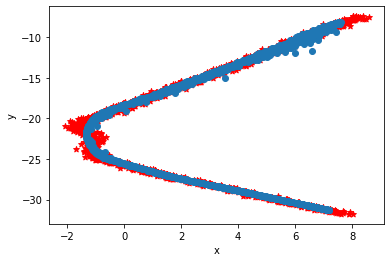

In [ ]:
plot_coordinates(model, X_all, y_all)

### Predicted points on blind test set

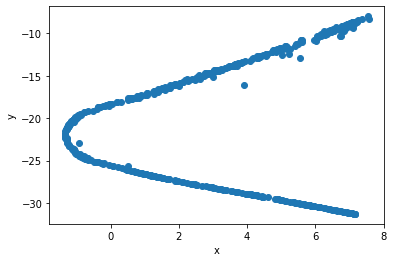

In [ ]:
plot_coordinates(model, blind_ts)

## Ensemble 

First we try using the bagging method with 10 estimators.

In [ ]:
bagging_ens = BaggingRegressor(model, n_estimators=10, n_jobs=-1, random_state=RS_NUMBER).fit(X, y)

In [ ]:
y_predicted_internal_ensemble = bagging_ens.predict(X_internal_test)
print(f"Accuracy: {model.score(X_internal_test, y_internal_test)}")
print(f"MEE: {mee(y_internal_test, y_predicted_internal_ensemble)}")

Accuracy: 0.931042189429351
MEE: 1.0988026961908495


Then we try the voting method using the 10 best models from the randomized search. 

In [ ]:
y_predictions_internal_test = list()
y_predictions_blind_test = list()

#fit every model
for model in best_models:
    model.fit(X,y)


#predictions on every model is averaged
for model in best_models:
    y_pred = model.predict(X_internal_test)
    y_predictions_internal_test.append(y_pred)
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)


In [ ]:
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

print(f"MEE: {mee(y_internal_test, y_pred_voting_ens_internal_test)}")

MEE: 1.0618897712376818


### Predicted points on internal test set using ensemble

#### BAGGING ENSEMBLE

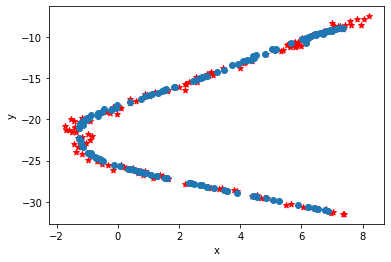

In [ ]:
#BAGGING ENSEMBLE
plot_coordinates(bagging_ens, X_internal_test, y_internal_test)

#### VOTING COMMITEE OF 10 BEST MODELS

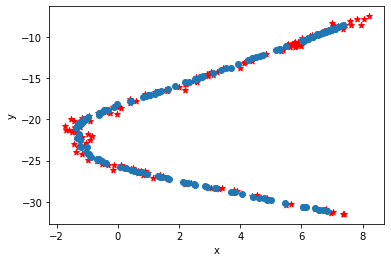

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_internal_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

### Predicted points on blind test set using Ensemble

#### BAGGING ENSEMBLE

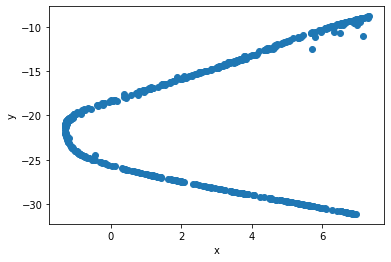

In [ ]:
#BAGGING ENSEMBLE
plot_coordinates(bagging_ens, blind_ts)

#### VOTING COMMITEE OF 10 BEST MODELS

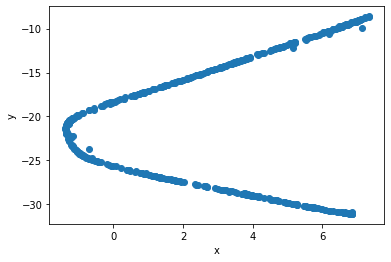

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_blind_test, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>